# Velib

Velib is the name of the bike sharing system of Paris.
Many people uses Velib to move around the city by staying healthy at the same time.

This system is used by so many people that data collection has become a vital part of the mantainance of the service, by estimating the density of the use we can predict the cost of mantainance by estimating the amount of usage, or provide more bikes where the service is more needed.

Data is structured as follow:
* Every minute data is collected from the 1217 stations in all paris.

* histo: a matrix (1217xminutes) the number of velib disponibles.

* take: a matrix (1217xminutes) the number of velib taken.

* stations: id_velib -> name,address,coord_y,coord_x,banking,bonus,number or places
 * id_velib are sparse, between {903 - 44102}
* idx_stations: id_velib -> matrix index (histo,take)
* stations_idx: matrix index (histo,take) -> id_velib

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fname = "velib.npz"
obj = np.load(fname)

histo = obj['histo']
take = obj['take']
stations = dict(obj['stations'].tolist())
idx_stations = dict(obj['idx_stations'].tolist())
stations_idx = dict(obj['stations_idx'].tolist()) 


# Density estimation.

We'll use the parzen window method to estimate the density function of the random variable: the amount of bikes at a given position.


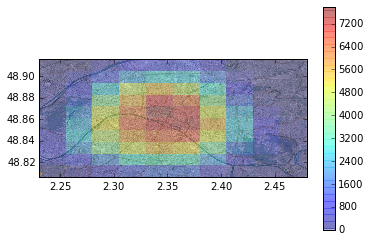

In [174]:
# load the image to plot data onto
parismap = mpimg.imread('paris-48.806-2.23--48.916-2.48.jpg')
## GPS coordinates
xmin,xmax = 2.23,2.48   ## coord_x min and max
ymin,ymax = 48.806,48.916 ## coord_y min and max

# create the data to contain the coordinates for each station
geo_mat = np.zeros((len(idx_stations),2))
for i,idx in idx_stations.items():
    geo_mat[i,0] =stations[idx][3]
    geo_mat[i,1]= stations[idx][2]

steps = 10
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]
density = np.zeros((steps,steps))
h = (xmax-xmin)/steps

def parzen_estimation(x,h):
    acc = 0
    for i in range(geo_mat.shape[0]):
        if np.linalg.norm(geo_mat[i]-x) < h:
            acc+= stations[idx_stations[i]][-1]
    return acc

def gaussian(x,sigma):
    """
        gaussian function of mean: x, stdev: sigma 
    """
    sigma2to2 = float(2*sigma**2)
    A = 1/float(np.sqrt(sigma2to2*np.pi))
    xx = x**2
    exponent = -( xx/sigma2to2  )
    return A*np.exp(exponent)

def gaussian_estimation(x,sigma):
    dist = np.linalg.norm(geo_mat[i]-x, 2)
    if dist < 3*sigma:
        w = gaussian(dist,sigma)
        return w
    return 0

for i,j in [(i,j) for i in range(steps) for j in range(steps)]:
    density[i,j] = parzen_estimation((xx[i,j],yy[i,j]),h)
    #density[i,j] = gaussian_estimation((xx[i,j],yy[i,j]),h)
    
plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.3)
plt.imshow(density,extent=[xmin,xmax,ymin,ymax],interpolation='none',\
               alpha=0.3,origin = "lower")

plt.colorbar()
plt.show()


In [ ]:
def gaussian(x,mu,sigma):
    """
        gaussian function of mean: mu, stdev: sigma 
    """
    sigma2to2 = 2*sigma**2
    nc = 1/np.sqrt(sigma2to2*np.pi)
    xx = (x-mu).dot(x-mu)
    exponent = ( xx/sigma2to2  )
    return nc*np.exp(-exponent)

In [105]:
def temporal_histogram(station, data, days_interval=1, delta=60):
    # default min_intervalis a day
    min_interval = days_interval*1440
    days = data.shape[1]/min_interval
    acc_histo = np.zeros(min_interval)
    discretization_step = min_interval/delta
    acc_histo_delta = np.zeros(discretization_step)
    N = np.sum(data[station])
    for day in range(days-1):
        acc_histo += data[station][day*min_interval:(day+1)*min_interval]
    for i in range(discretization_step-1):
        acc_histo_delta[i] = np.sum(acc_histo[i*delta:(i+1)*delta])
    return acc_histo_delta/N/delta
        
stations_n,overall_t = take.shape
hourly_time_density = {}
for stat in range(stations_n):
    hourly_time_density[stat] = temporal_histogram(stat,take)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


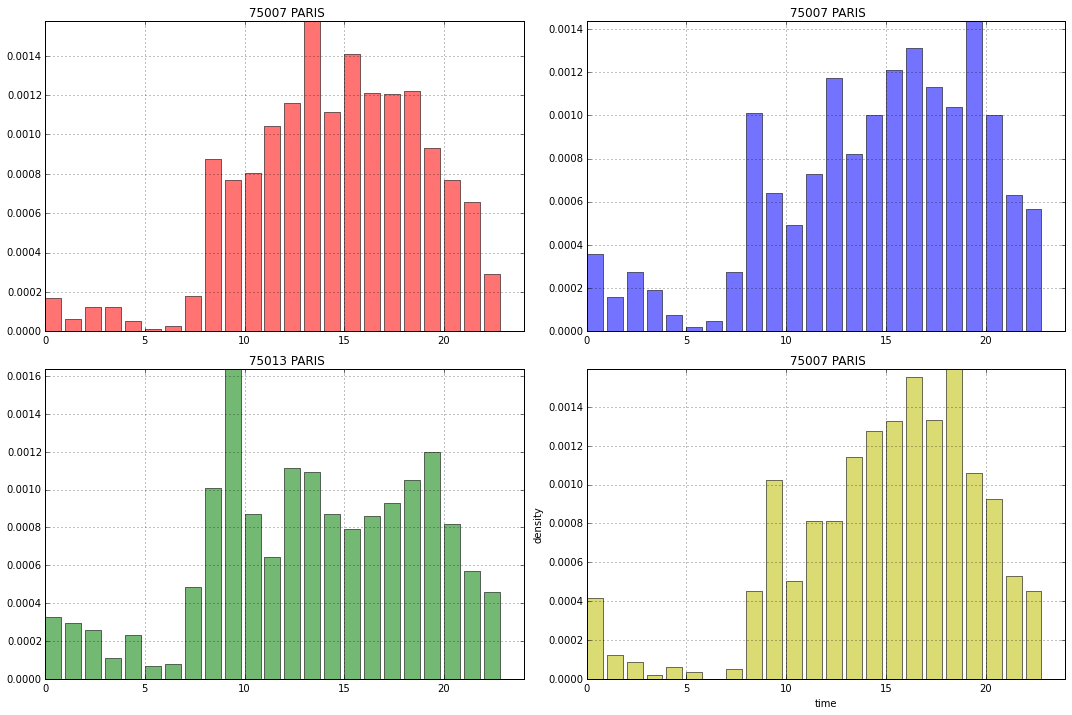

In [142]:
# the histogram of the data
hours_a_day = 24
indices = [1,40,502,1003]
colors = ['r','g','b','y']
f, axarr = plt.subplots(2, len(indices)/2,figsize=(15,10))
for i in range(len(indices)):
    stat_id = idx_stations[i]
    h = np.max(hourly_time_density[i])
    axarr[i%2,i/2].bar(range(hours_a_day), hourly_time_density[i], facecolor=colors[i%len(colors)], alpha=0.55)
    axarr[i%2,i/2].set_title(stations[stat_id][1][-12:])
    axarr[i%2,i/2].grid(True)
    plt.xlabel('time')
    plt.ylabel('density')
    axarr[i%2,i/2].axis([0, 24, 0, h])
    plt.tight_layout() 

    #axarr[i%2,i/2].xlabel('time')
    #axarr[i%2,i/2].ylabel('density')
    #axarr[i%2,i/2].title('Histogram method')
    #axarr[i%2,i/2].axis([0, 24, 0, h])
    #axarr[i%2,i/2].grid(True)
plt.xlabel('time')
plt.ylabel('density')
plt.tight_layout() 
plt.show()

In [108]:
        
stations_n,overall_t = take.shape
twenty_min_time_density = {}
for stat in range(stations_n):
    twenty_min_time_density[stat] = temporal_histogram(stat,take,1,20)
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


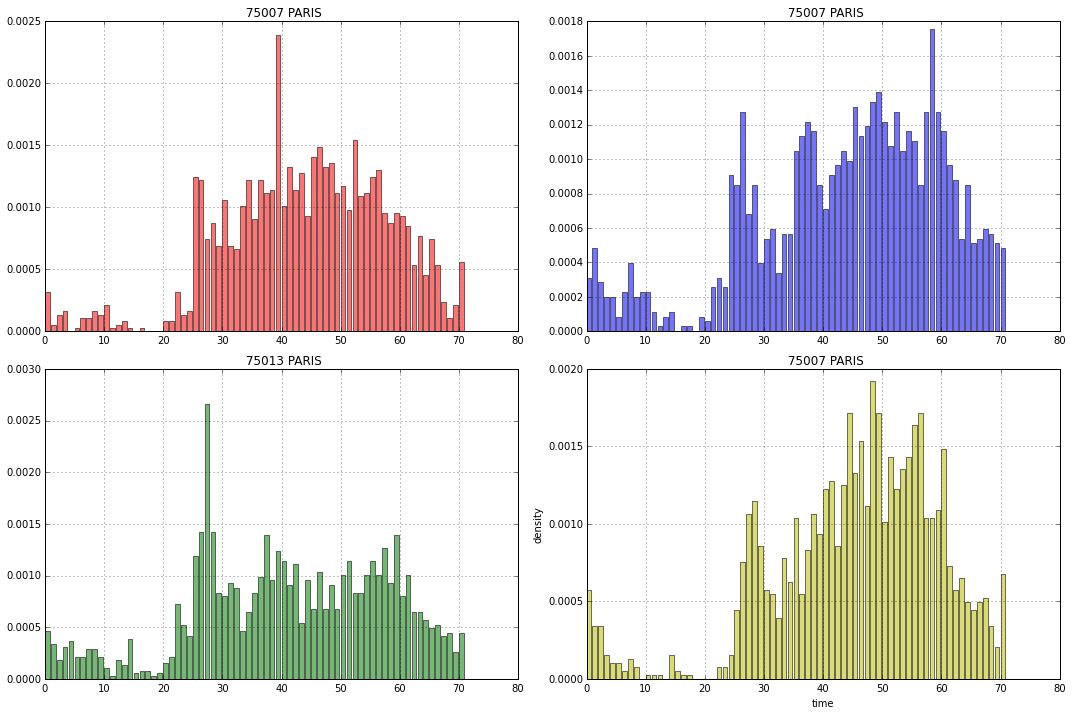

In [144]:
indices = [1,40,502,1003]
colors = ['r','g','b','y']
f, axarr = plt.subplots(2, len(indices)/2,figsize=(15,10))
twenty_min_a_day = 72
for i in range(len(indices)):
    stat_id = idx_stations[i]
    axarr[i%2,i/2].bar(range(twenty_min_a_day), twenty_min_time_density[i], facecolor=colors[i%len(colors)], alpha=0.55)
    axarr[i%2,i/2].set_title(stations[stat_id][1][-12:])
    plt.xlabel('time')
    plt.ylabel('density')
    plt.tight_layout() 
    axarr[i%2,i/2].grid(True)

plt.xlabel('time')
plt.ylabel('density')
plt.tight_layout() 
plt.show()

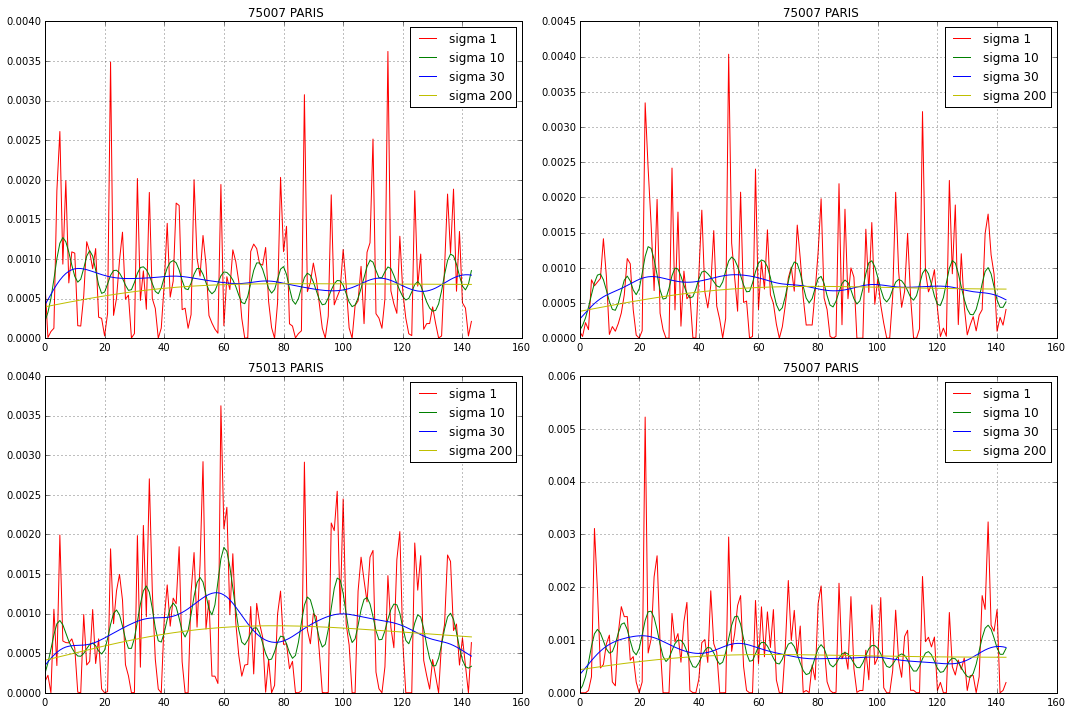

In [141]:
def gaussian_kernel(sigma):
    def f(x,mu):
        exponent = ( (x-mu)**2/float(2*(sigma**2)) )
        coeff_normalizazz = 1/float(np.sqrt(2*(sigma**2)*np.pi))
        return coeff_normalizazz*np.exp(-exponent)
    return f

def gaussian_window(x):
    return np.sqrt(2*np.pi)*np.exp(-0.5*x**2)

def kernel_temporal_histogram(time, kernel, days_interval=1, delta=10):
    # default min_intervalis a day
    min_per_day = 60*24
    # number of minutes per specified days
    min_interval = days_interval*min_per_day
    # number of days in the dataset
    days = time.shape[0]/min_interval
   
    N = np.sum(time[:min_interval*days])
    x_time = np.sum(time[:min_interval*days].reshape(min_interval,days),axis=1)/N
    x_domain = np.arange(min_interval)    
    dt = min_interval/delta
    p_x_time = np.zeros(dt)
    vkernel = np.vectorize(kernel)
    for dti in range(dt):
        p_x_time[dti] = np.sum(vkernel(x_domain-dti*delta/2,0)*x_time)
    return p_x_time

sigmas = [1.,10.,30.,200.]
indices = [1,40,502,1003]
colors = ['r','g','b','y']
f, axarr = plt.subplots(2, len(indices)/2,figsize=(15,10))
for i in range(len(indices)):
    stat_id = idx_stations[i]
    axarr[i%2,i/2].set_title(stations[stat_id][1][-12:])
    plots = []
    for j in range(len(sigmas)):
        pi = kernel_temporal_histogram(take[indices[i]],gaussian_kernel(sigmas[j]))
        plot, = axarr[i/2,i%2].plot(pi,colors[j%len(colors)],label="sigma %.0f" % sigmas[j])
        axarr[i/2,i%2].grid(True)
        plots += [plot]
    axarr[i/2,i%2].legend(handles=plots)
plt.tight_layout() 
plt.grid(True)
plt.show()

0.0884397745307
